In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import requests

plt.style.use('ggplot')

## Data loading

,Vekt (tonn),Kilopris (kr)
uke,,
2000-01-03,3728,30.98
2000-01-10,4054,31.12
2000-01-17,4043,31.03
2000-01-24,3730,30.95
2000-01-31,3831,31.30
...,...,...
2023-07-17,17898,92.67
2023-07-24,19604,86.14
2023-07-31,20469,83.28


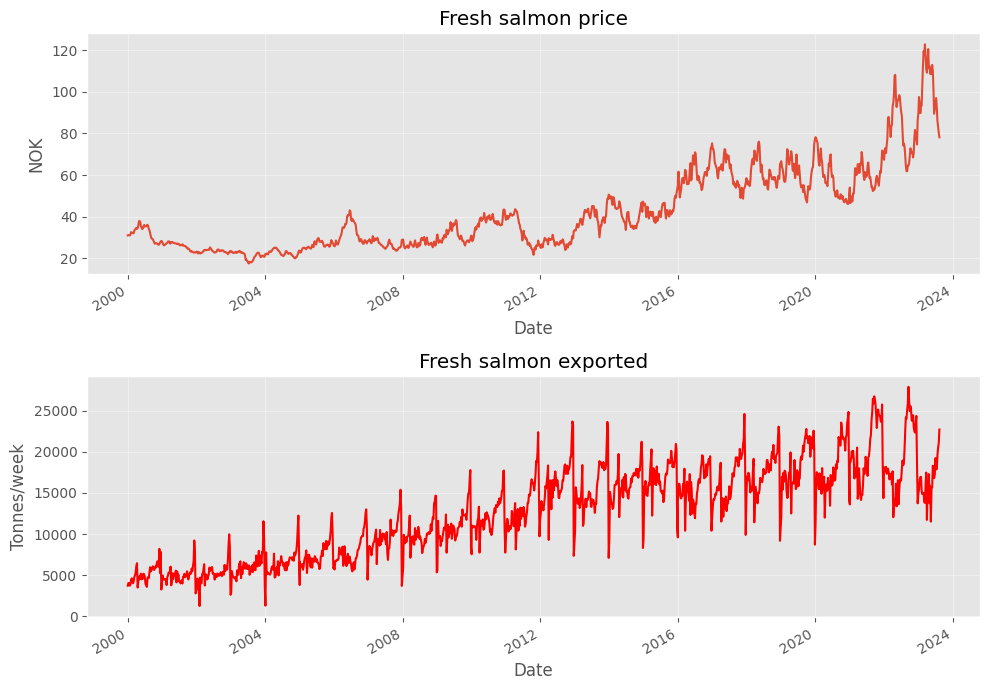

In [232]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

json_response = requests.get(data_URL).json()

price = pd.Series(json_response['dataset']['value'][1::2], name='Kilopris (kr)')
volume = pd.Series(json_response['dataset']['value'][::2], name='Vekt (tonn)')
index = pd.Series(json_response['dataset']['dimension']['Tid']['category']['label'].values(), name='uke')

data = pd.DataFrame({'uke':index, 'Vekt (tonn)':volume, 'Kilopris (kr)':price})

# Change index to datetime format
date_series = pd.to_datetime(data['uke'].str[:4] + data['uke'].str[-2:] + '1', format='%Y%W%w')
data.set_index(date_series, inplace=True)
data.drop(['uke'], axis=1, inplace=True)

display(data)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Kilopris (kr)'].plot(ax=ax1, ylabel='NOK')
data['Vekt (tonn)'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()

## Feature extraction

,Vekt (tonn),Kilopris (kr),Year,Week,Month,Day of year
uke,,,,,,
2000-01-03,3728,30.98,2000,1,1,3
2000-01-10,4054,31.12,2000,2,1,10
2000-01-17,4043,31.03,2000,3,1,17
2000-01-24,3730,30.95,2000,4,1,24
2000-01-31,3831,31.30,2000,5,1,31
...,...,...,...,...,...,...
2023-07-17,17898,92.67,2023,29,7,198
2023-07-24,19604,86.14,2023,30,7,205
2023-07-31,20469,83.28,2023,31,7,212


<Axes: xlabel='Week', ylabel='Vekt (tonn)'>

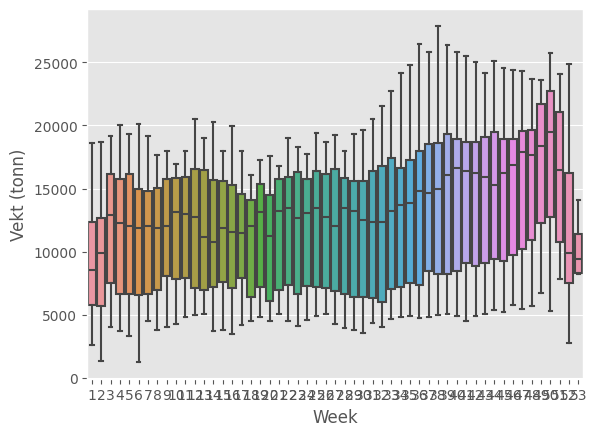

In [233]:
# Add lag faetures
def add_lags(df):
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week.astype(int)
    df['Month'] = df.index.month
    df['Day of year'] = df.index.dayofyear

add_lags(data)

display(data)

sns.boxplot(data=data, x='Week', y='Vekt (tonn)')

## Model training

In [234]:
train, test = train_test_split(data, test_size=0.30, shuffle=True)

features = ['Year', 'Week', 'Month', 'Day of year']
targets = ['Vekt (tonn)', 'Kilopris (kr)']

x_train = train[features]
y_train = train[targets]

x_test = test[features]
y_test = test[targets]

reg_model = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=1000)

reg_model.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_test, y_test)], 
    verbose=True
)

[0]	validation_0-rmse:6930.91614	validation_1-rmse:6892.81809


[1]	validation_0-rmse:4941.31498	validation_1-rmse:4973.57505
[2]	validation_0-rmse:3549.41306	validation_1-rmse:3640.79273
[3]	validation_0-rmse:2577.84943	validation_1-rmse:2736.97245
[4]	validation_0-rmse:1909.11643	validation_1-rmse:2131.56070
[5]	validation_0-rmse:1451.69828	validation_1-rmse:1741.47640
[6]	validation_0-rmse:1144.66186	validation_1-rmse:1515.21884
[7]	validation_0-rmse:935.59457	validation_1-rmse:1354.50034
[8]	validation_0-rmse:804.70778	validation_1-rmse:1268.86065
[9]	validation_0-rmse:719.84593	validation_1-rmse:1227.40013
[10]	validation_0-rmse:655.85060	validation_1-rmse:1193.98645
[11]	validation_0-rmse:619.60964	validation_1-rmse:1181.59568
[12]	validation_0-rmse:588.19656	validation_1-rmse:1172.16176
[13]	validation_0-rmse:571.03133	validation_1-rmse:1166.74390
[14]	validation_0-rmse:559.01810	validation_1-rmse:1165.44468
[15]	validation_0-rmse:546.67343	validation_1-rmse:1159.82127
[16]	validation_0-rmse:535.26055	validation_1-rmse:1156.04764
[17]	valida

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Model prediction

,Importance
Year,0.674946
Week,0.211320
Month,0.070608
Day of year,0.043125


,Date,Year,Week,Month,Day of year
Date,,,,,
2023-08-07,2023-08-07,2023,32,8,219
2023-08-08,2023-08-08,2023,32,8,220
2023-08-09,2023-08-09,2023,32,8,221
2023-08-10,2023-08-10,2023,32,8,222
2023-08-11,2023-08-11,2023,32,8,223
...,...,...,...,...,...
2025-12-20,2025-12-20,2025,51,12,354
2025-12-21,2025-12-21,2025,51,12,355
2025-12-22,2025-12-22,2025,52,12,356


Week 43:


,2023-10-23
Vekt (tonn),23802.777344
Kilopris (kr),76.167679


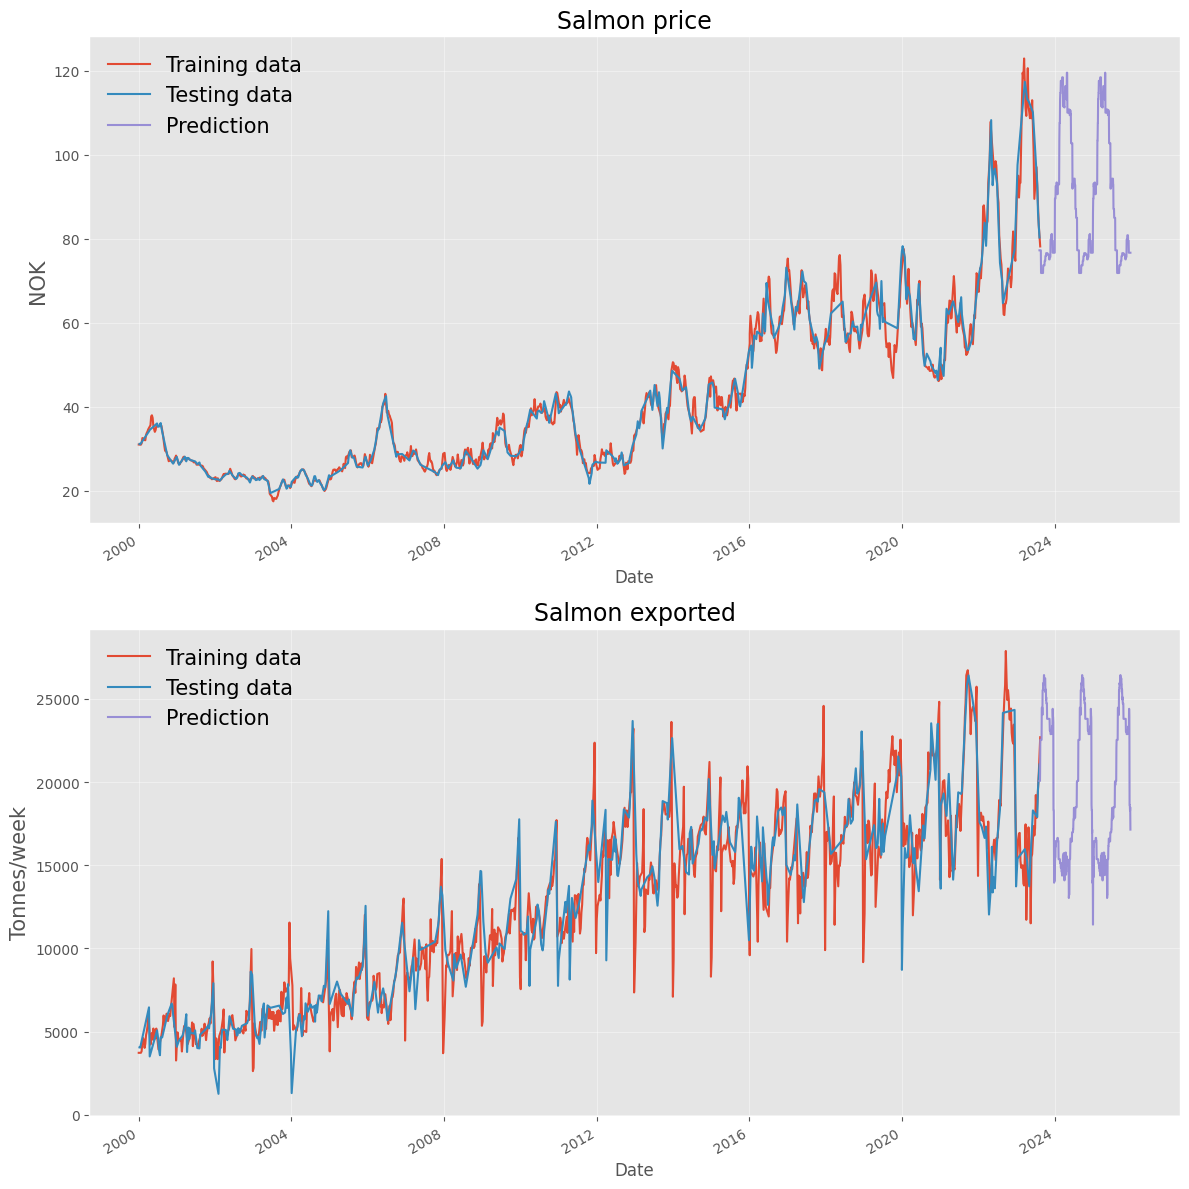

In [235]:
fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
display(fi)

future_dates = pd.DataFrame(
    pd.date_range(
        start=x_test.sort_values(by='uke').index[-1], 
        end='2025-12-24'
    ), columns=['Date']
)

future_dates.set_index(future_dates['Date'], inplace=True)
add_lags(future_dates)

display(future_dates)

future_dates.drop('Date', axis=1, inplace=True)

predictions = pd.DataFrame(reg_model.predict(future_dates), columns=targets, index=future_dates.index)

fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, data in enumerate([y_train, y_test, predictions]):
        data[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# Week 43:
print('Week 43:')
display(pd.DataFrame(predictions.loc['2023-10-23']))